In [10]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [40]:
# Load the data
peptides_df = pd.read_csv('train_peptides.csv')
proteins_df = pd.read_csv('train_proteins.csv')
clinical_df = pd.read_csv('train_clinical_data.csv')

In [39]:
peptides_df_encoded

,visit_month,patient_id,PeptideAbundance,visit_id_10053_0,visit_id_10053_12,visit_id_10053_18,visit_id_10138_12,visit_id_10138_24,visit_id_10138_36,visit_id_10174_0,...,Peptide_YSLTYIYTGLSK,Peptide_YTTEIIK,Peptide_YVGGQEHFAHLLILR,Peptide_YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,Peptide_YVMLPVADQDQC(UniMod_4)IR,Peptide_YVNKEIQNAVNGVK,Peptide_YWGVASFLQK,Peptide_YYC(UniMod_4)FQGNQFLR,Peptide_YYTYLIMNK,Peptide_YYWGGQYTWDMAK
0,0,55,11254.30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,55,102060.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,55,174185.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,55,27278.90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,55,30838.70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981829,108,58648,202820.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
981830,108,58648,105830.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
981831,108,58648,21257.60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
981832,108,58648,5127.26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
clinical_df_encoded

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,visit_id_10053_0,visit_id_10053_12,visit_id_10053_18,visit_id_10053_24,...,visit_id_942_42,visit_id_942_48,visit_id_942_54,visit_id_942_6,visit_id_942_60,visit_id_942_72,visit_id_942_84,visit_id_942_96,upd23b_clinical_state_on_medication_Off,upd23b_clinical_state_on_medication_On
0,55,0,10.0,6.0,15.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55,3,10.0,7.0,25.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55,6,8.0,10.0,34.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55,9,8.0,9.0,30.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,55,12,10.0,10.0,41.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043,48,7.0,6.0,13.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2611,65043,54,4.0,8.0,11.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2612,65043,60,6.0,6.0,16.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2613,65043,72,3.0,9.0,14.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
col_encode_peptides = ['UniProt', 'Peptide']
peptides_df_encoded = pd.get_dummies(peptides_df, columns=col_encode_peptides)

In [42]:
col_encode_proteins = ['UniProt']
proteins_df_encoded = pd.get_dummies(proteins_df, columns=col_encode_proteins)

In [43]:
col_encode_clinical = ['upd23b_clinical_state_on_medication']
clinical_df_encoded = pd.get_dummies(clinical_df, columns=col_encode_clinical)

In [35]:
clinical_df_encoded['updrs_1'].isna().sum()

1

In [44]:
from sklearn.impute import SimpleImputer

# create an instance of the SimpleImputer class with strategy='median'
imputer = SimpleImputer(strategy='median')

# fit the imputer to the training data
imputer.fit(clinical_df_encoded[['updrs_1']])
imputer.fit(clinical_df_encoded[['updrs_2']])
imputer.fit(clinical_df_encoded[['updrs_3']])
imputer.fit(clinical_df_encoded[['updrs_4']])

# impute the missing values in the training and test data
clinical_df_encoded['updrs_1'] = imputer.transform(clinical_df_encoded[['updrs_1']])
clinical_df_encoded['updrs_2'] = imputer.transform(clinical_df_encoded[['updrs_2']])
clinical_df_encoded['updrs_3'] = imputer.transform(clinical_df_encoded[['updrs_3']])
clinical_df_encoded['updrs_4'] = imputer.transform(clinical_df_encoded[['updrs_4']])

/Users/sherahuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- updrs_1
Feature names seen at fit time, yet now missing:
- updrs_4

  warnings.warn(message, FutureWarning)
/Users/sherahuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- updrs_2
Feature names seen at fit time, yet now missing:
- updrs_4

  warnings.warn(message, FutureWarning)
/Users/sherahuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- updrs_3
Feature names seen at fit time, yet now m

In [ ]:
merged_df = peptides_df_encoded.merge(proteins_df_encoded, on=['visit_id', 'visit_month', 'patient_id'])
merged_df = merged_df.merge(clinical_df_encoded, on=['visit_id', 'visit_month', 'patient_id'])


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define the model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(merged_df.shape[1], merged_df.shape[2])))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Preprocess the data
scaler = StandardScaler()
merged_df = scaler.fit_transform(merged_df.reshape(-1, X_train.shape[-1])).reshape(merged_df.shape)
#X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

le = LabelEncoder()
#y_train_encoded = le.fit_transform(y_train)
#y_test_encoded = le.transform(y_test)

# Train the model
#model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
#loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {accuracy}")


/var/folders/1m/qlgvd1tj4zj_xvwlsjfgf8g40000gn/T/ipykernel_16099/2349492479.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  protein_data.loc[(patient_id, protein), 'NPX'].plot()


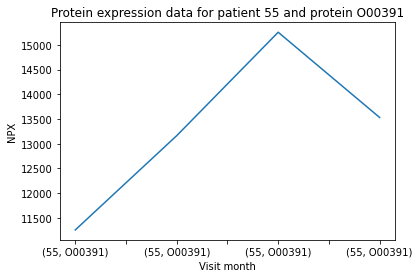

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the protein expression data
protein_data = pd.read_csv('train_proteins.csv')

# Convert the visit_month column to a datetime format
protein_data['visit_month'] = pd.to_datetime(protein_data['visit_month'], format='%Y-%m')

# Set the patient_id and UniProt columns as the index
protein_data.set_index(['patient_id', 'UniProt'], inplace=True)

# Plot the time series graph for the protein expression data of a specific patient and protein
patient_id = 55
protein = 'O00391'
protein_data.loc[(patient_id, protein), 'NPX'].plot()
plt.title(f"Protein expression data for patient {patient_id} and protein {protein}")
plt.xlabel('Visit month')
plt.ylabel('NPX')
plt.show()


# Deep learning - LSTM (long short-term memory networks)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define the model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Preprocess the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train the model
model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {accuracy}")


In [1]:
import pandas as pd

peptides = pd.read_csv('train_peptides.csv')
proteins = pd.read_csv('train_proteins.csv')
clinical_data = pd.read_csv('train_clinical_data.csv')

data = pd.merge(peptides, proteins, on=['visit_id', 'visit_month', 'patient_id', 'UniProt'], how='left')
data = pd.merge(data, clinical_data, on=['visit_id', 'visit_month', 'patient_id'], how='left')


In [3]:
print(data.isna())

        visit_id  visit_month  patient_id  UniProt  Peptide  PeptideAbundance  \
0          False        False       False    False    False             False   
1          False        False       False    False    False             False   
2          False        False       False    False    False             False   
3          False        False       False    False    False             False   
4          False        False       False    False    False             False   
...          ...          ...         ...      ...      ...               ...   
981829     False        False       False    False    False             False   
981830     False        False       False    False    False             False   
981831     False        False       False    False    False             False   
981832     False        False       False    False    False             False   
981833     False        False       False    False    False             False   

          NPX  updrs_1  upd

In [9]:
import pandas as pd

# One-hot encode the upd23b_clinical_state_on_medication column
one_hot = pd.get_dummies(data['upd23b_clinical_state_on_medication'])

# Drop the original column from the DataFrame
df = data.drop('upd23b_clinical_state_on_medication', axis=1)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, one_hot], axis=1)

# Print the updated DataFrame
print(df.head())


  visit_id  visit_month  patient_id UniProt  \
0     55_0            0          55  O00391   
1     55_0            0          55  O00533   
2     55_0            0          55  O00533   
3     55_0            0          55  O00533   
4     55_0            0          55  O00533   

                                  Peptide  PeptideAbundance       NPX  \
0                           NEQEQPLGQWHLS           11254.3   11254.3   
1                             GNPEPTFSWTK          102060.0  732430.0   
2                         IEIPSSVQQVPTIIK          174185.0  732430.0   
3  KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK           27278.9  732430.0   
4                            SMEQNGPGLEYR           30838.7  732430.0   

   updrs_1  updrs_2  updrs_3  updrs_4  Off  On  
0     10.0      6.0     15.0      NaN    0   0  
1     10.0      6.0     15.0      NaN    0   0  
2     10.0      6.0     15.0      NaN    0   0  
3     10.0      6.0     15.0      NaN    0   0  
4     10.0      6.0     15.0     

In [4]:
# Replace missing values with the mean of neighboring values
data1 = data.fillna(method='ffill', inplace=True)